# 線形回帰（単一パラメータ）に対するラプラス近似

「Juliaで作って学ぶベイズ統計学」P.172 参照

In [1]:
using Distributions
using Plots
using ForwardDiff
using LinearAlgebra

## 観測データ

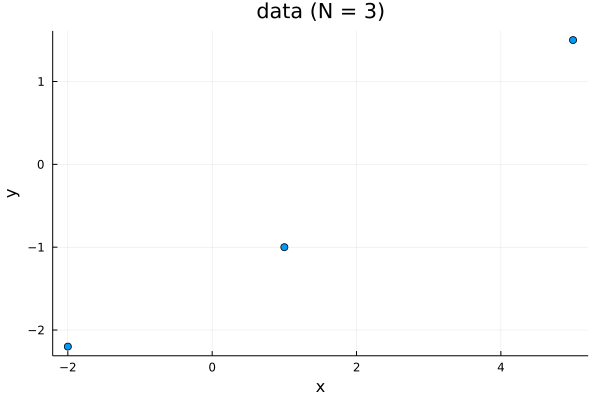

In [2]:
X_obs = [
    -2.0
    1.0
    5.0
]

Y_obs = [
    -2.2
    -1.0
    1.5
]

scatter(X_obs, Y_obs, xlab="x", ylab="y", label=:none, title="data (N = $(length(X_obs)))")

## ラプラス近似

In [3]:
# 非正規化対数事後分布
log_joint(w₁, X, Y, w₂, σ, μ₁, σ₁) =
　　 sum(logpdf.(Normal.(w₁ * X .+ w₂, σ), Y)) +
    logpdf(Normal(μ₁, σ₁), w₁)

log_joint (generic function with 1 method)

In [4]:
# 勾配法（1dim）
function gradient_method_1dim(f, x_init, η, maxiter)
    fʼ(x) = ForwardDiff.derivative(f, x)
    x_seq = Array{typeof(x_init), 1}(undef, maxiter)
    x_seq[1] = x_init
    for i in 2:maxiter
        x_seq[i] = x_seq[i-1] + η * fʼ(x_seq[i-1])
    end
    x_seq
end

gradient_method_1dim (generic function with 1 method)

In [5]:
# 最適化のラッパー関数の定義
function inference_wrapper_gd_1dim(log_joint, params, w₁_init, η, maxiter)
    ulp(w₁) = log_joint(w₁, params...)
    w₁_seq = gradient_method_1dim(ulp, w₁_init, η, maxiter)
    w₁_seq
end

inference_wrapper_gd_1dim (generic function with 1 method)

In [6]:
# 切片はゼロで固定
w₂ = 0

# yに付加されるノイズの標準偏差
σ = 1.0

# 事前分布のパラメータ
μ₁ = 0.0
σ₁ = 10.0

params = (X_obs, Y_obs, w₂, σ, μ₁, σ₁)

# 最適化パラメータ
w₁_init = 0.0
η = 0.01
maxiter = 100

# 最適化の実施
w₁_seq = inference_wrapper_gd_1dim(log_joint, params, w₁_init, η, maxiter);

In [7]:
# 近似分布用の平均を求める
μ_approx = w₁_seq[end];

In [8]:
ulp(w₁) =
　　 sum(logpdf.(Normal.(w₁ * X_obs .+ w₂, σ), Y_obs)) +
    logpdf(Normal(μ₁, σ₁), w₁)

ulp (generic function with 1 method)

In [9]:
# 2階微分から分散を求める
grad(x) = ForwardDiff.derivative(ulp, x)
hessian(x) = ForwardDiff.derivative(grad, x)
σ_approx = √(inv(-hessian(μ_approx)));

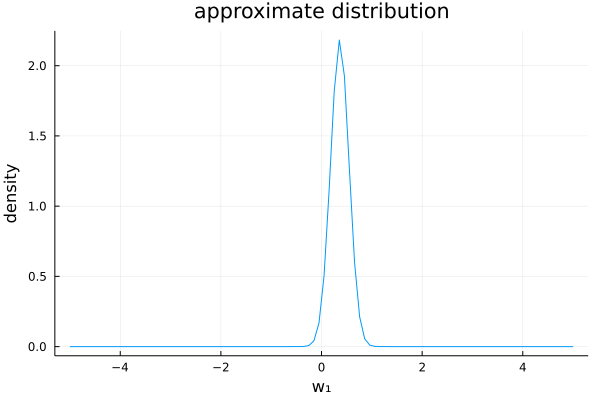

In [10]:
# 分布を表示する範囲
w₁s = range(-5, 5, length=100)

# 得られた近似分布の可視化
plot(w₁s, pdf.(Normal.(μ_approx, σ_approx), w₁s), 
     xlab="w₁", ylab="density", title="approximate distribution", label=:none)